In [2]:
from pathlib import Path
import pandas as pd
import subprocess
import re
import matplotlib.pyplot as plt

In [3]:
BASE_PATH = Path("scalability")

pattern = r"([\d.]+)"

workloads = ["1000000_keys", "2000000_keys", "5000000_keys"]
#workloads = ["1000000_keys"]

yticks = [
    [i for i in range(0, 41, 5)],
    [i for i in range(0, 46, 5)],
    [i for i in range(0, 276, 25)],
    [i for i in range(0, 401, 50)],
]

In [126]:
def plot_graphs(df, num_keys, own_labels, ylabel="elapsed_time", yticks=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))  # width, height
    if own_labels.get("title"):
        title = own_labels.get("title")
        fig.suptitle(f"RocksDB Benchmark:\n{title}", size=16, y=1.05)
    else:
        fig.suptitle(f"RocksDB Benchmark:\nSequential/random writing", size=16, y=1.05)

    for i, col in enumerate(["writeseq", "writerandom"]):
        ax = axes[i]

        for num in num_keys: # [1000000, 2000000, 5000000]
            tmp_df = df[df["num_keys"] == num]
            tmp_df = tmp_df[tmp_df["workload_type"] == col].sort_values("threads")

            tmp_df.plot(ax=ax, x="threads", y=ylabel, label=str(num) + " keys", marker='o')

            if i != len(["writeseq", "writerandom"])-1:
                ax.legend_.remove()
            else:
                ax.legend(bbox_to_anchor=(1.04, 1.27))

            ax.set_xlabel(own_labels["suptitle"][i], weight='bold', size=14)
            ax.xaxis.set_label_position('top')
            plt.figtext(0.3, -0.01, 'Threads', ha='center', va='center', size=14)
            plt.figtext(0.72, -0.01, 'Threads', ha='center', va='center', size=14)
            ax.set_ylabel(own_labels["ylabel"], size=14)
            ax.yaxis.grid(visible=True, which='major', color='black', linestyle='--', alpha=.4)
            ax.xaxis.grid(visible=True, which='major', color='black', linestyle='--', alpha=.4)
            ax.set_axisbelow(True)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.set_xticks([1, 4, 8, 16, 32])
            if yticks:
                ax.set_yticks(yticks)
            

            for tick in ax.get_xticklabels():
                tick.set_rotation(0)

In [127]:
def get_df(BASE_PATH, workloads, pattern, num_keys, labels, offset=2, value_name="elapsed_time"):
    base_df = pd.DataFrame()
    for idx, w in enumerate(workloads):
        w_list = list()

        p = BASE_PATH / w
        perf_stat_files = list(p.glob("*.txt"))

        for p in perf_stat_files:
            
            parts = p.name.split("_")

            w_type = parts[2] + parts[3]
            #keysize = int(parts[3])
            threads = int(parts[-2])

            cmd = f"tail -n -{offset} {p} | head -n 1"
            el_str = subprocess.check_output(cmd, shell=True).decode("utf-8").strip()
            match = re.search(pattern, el_str)
            if match:
                el = float(match.group(0))

            w_dict = {"workload_type": w_type, "threads": threads, value_name: el, "num_keys": num_keys[idx]}
            w_list.append(w_dict)
        df = pd.DataFrame(w_list)
        base_df = pd.concat([base_df, df])
    
    #plot_graphs(df, w.split("_")[0], ylabel=value_name)
    plot_graphs(base_df, num_keys, labels, ylabel=value_name)

In [107]:
labels = {"ylabel": "Seconds", "suptitle": ["fillseq", "fillrandom"]}

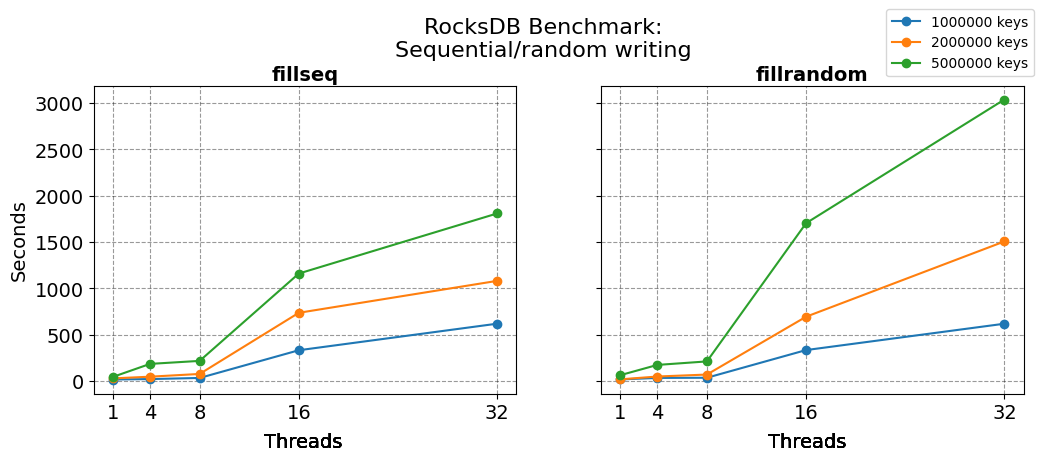

In [108]:
get_df(BASE_PATH, workloads, r"([\d.]+)", [1000000, 2000000, 5000000], labels)

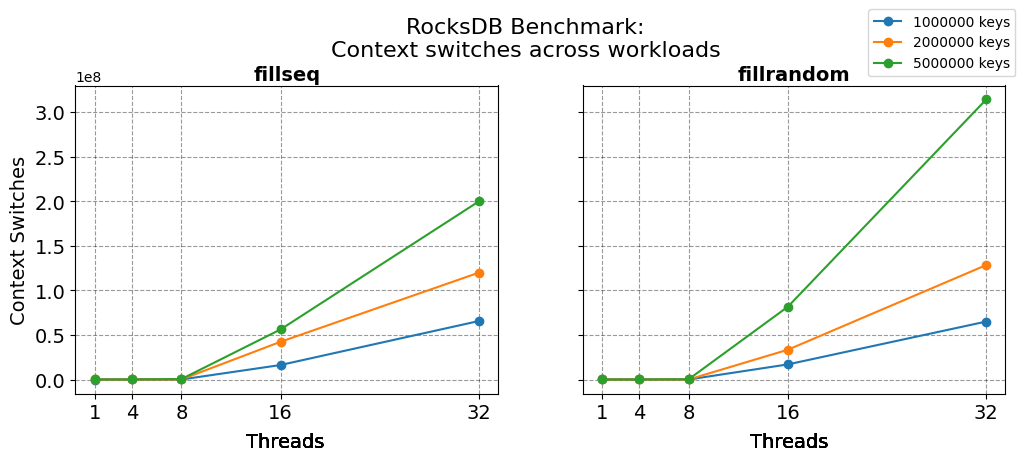

In [128]:
labels = {"ylabel": "Context Switches", "suptitle": ["fillseq", "fillrandom"], "title": "Context switches across workloads"}
get_df(BASE_PATH, workloads, r'\b\d+\b', [1000000, 2000000, 5000000], labels, 13, "context_switches")

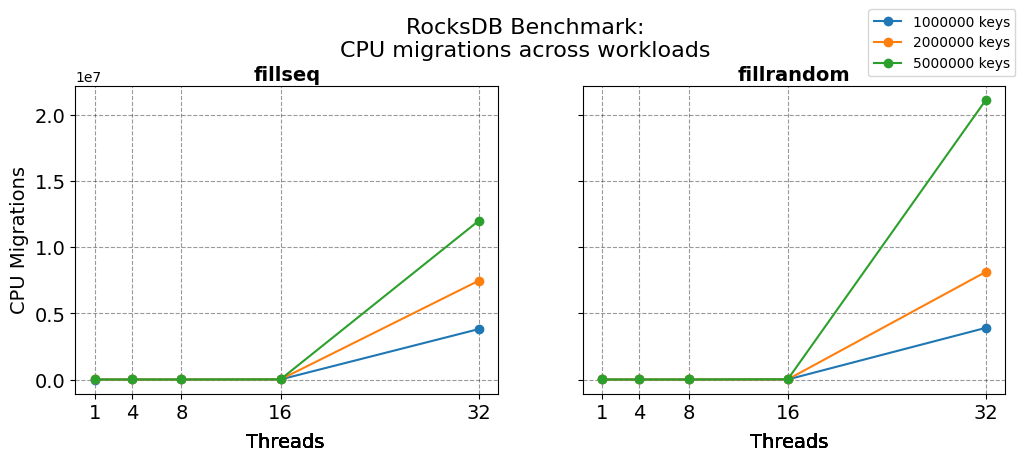

In [131]:
labels = {"ylabel": "CPU Migrations", "suptitle": ["fillseq", "fillrandom"], "title": "CPU migrations across workloads"}
get_df(BASE_PATH, workloads, r'\b\d+\b', [1000000, 2000000, 5000000], labels, 12, "cpu_migrations")

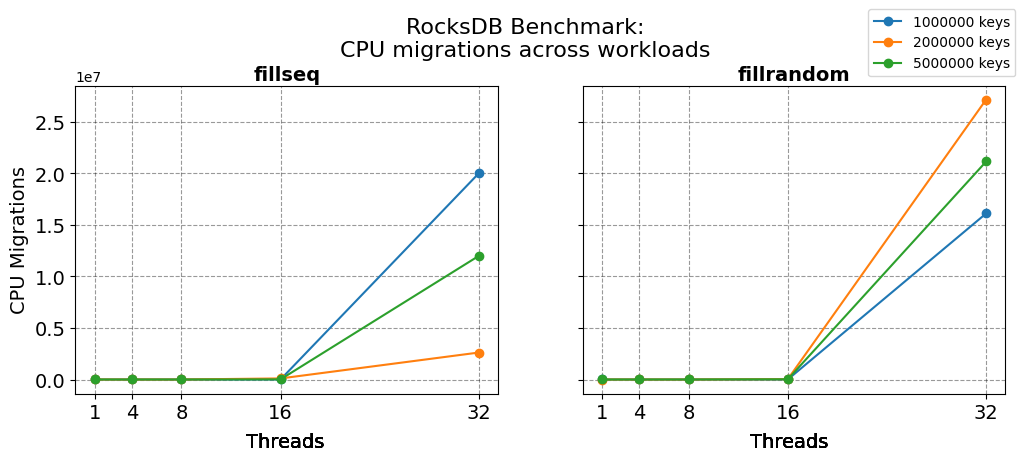

In [130]:
labels = {"ylabel": "CPU Migrations", "suptitle": ["fillseq", "fillrandom"], "title": "CPU migrations across workloads"}
get_df(BASE_PATH, workloads, r'\b\d+\b', [1000000, 2000000, 5000000], labels, 12, "cpu_migrations")

In [6]:
BASE_PATH = Path("scalability")
variance_dir = BASE_PATH / "variance"

In [10]:
pattern = r'^(\d+)m(\d+\.\d+)s$'
regex = re.compile(pattern)
seconds = list()

with open(variance_dir / "output.txt", 'r') as f:
    for line in f:
        if line.startswith('real'):
            fields = line.split()
            field = fields[1]

            match = regex.match(field)
            secs = float(match.group(2))
            seconds.append(secs)

In [12]:
from statistics import mean, stdev

In [14]:
print("Measurements", seconds)

print(f"Max running time {max(seconds)}")
print(f"Min running time {min(seconds)}")
print(f"Mean of measurements {mean(seconds)}")
print(f"Std dev of measurements {stdev(seconds)}")

Measurements [21.51, 16.541, 13.052, 20.1, 17.405, 20.687, 21.038, 21.068, 20.787, 20.66]
Max running time 21.51
Min running time 13.052
Mean of measurements 19.2848
Std dev of measurements 2.746581827168696
